In [15]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from keras.models import Sequential,Model
from keras.layers import Dense
from keras.layers import LSTM,SimpleRNN
from keras.layers import Dropout,GRU,Flatten
from keras.layers import TimeDistributed
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential, load_model
import tensorflow as tf
from keras.optimizers import Adam,Adamax,Nadam
import matplotlib.pyplot as plt

In [16]:
df=pd.read_csv('exoTrain.csv')
Y=df.loc[:,df.columns=="LABEL"]
X=df.loc[:,df.columns!="LABEL"]
Xtrain =X
Xtrain = Xtrain.to_numpy()
Y =Y.to_numpy()


# Skip the data preprocessing block

Applying Fourier Transform...
[[ 31822.48         3542.69725989  55671.61280692 ...  52952.70195631
   55671.61280692   3542.69725989]
 [ 23747.1         18904.03483095  23034.01375377 ...  23943.70167127
   23034.01375377  18904.03483095]
 [ 26180.51       143610.48759074  41912.29468855 ... 365999.61678651
   41912.29468855 143610.48759074]
 ...
 [  9398.42000001   5514.03371502  18216.47890902 ...   7032.65269996
   18216.47890902   5514.03371502]
 [  2567.54         1986.45522747   2780.97513937 ...   3810.82651497
    2780.97513937   1986.45522747]
 [ 16608.95000001  12716.78586068  20542.92617575 ...   8212.03658663
   20542.92617575  12716.78586068]] (5087, 3197)


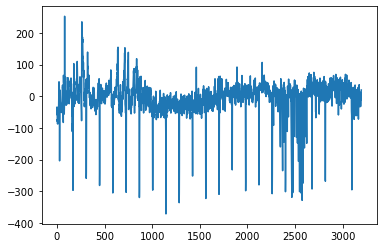

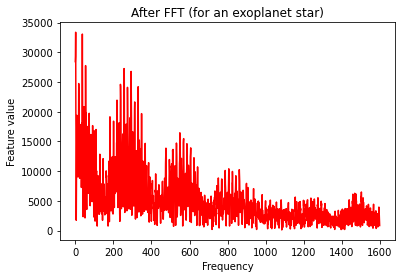

Normalizing...


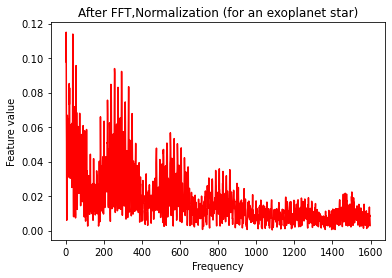

Applying Gaussian filter...


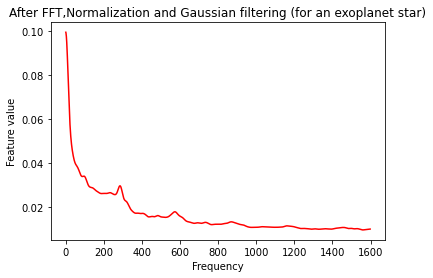

Applying MinMaxScaler...


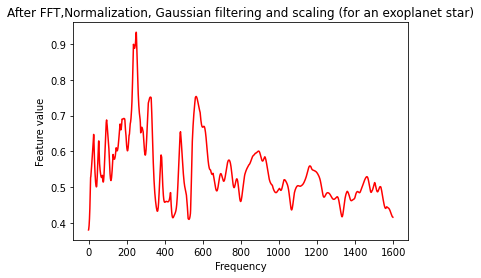

In [17]:
from scipy.fftpack import fft,ifft
#standard data preprocessing before feeding it to the LSTM 
m=100
def preprocess(Xtrain):
    print('Applying Fourier Transform...')
    plt.figure(5)
    plt.plot(Xtrain[1])
    Xtrain=np.abs(fft(Xtrain,n=len(Xtrain[m]),axis=1))
    print(Xtrain,Xtrain.shape)

    Xtrain=Xtrain[:,:1+int((len(Xtrain[0])-1)/2)]

    plt.figure(1)
    save_train_m = Xtrain[m]
    plt.plot(Xtrain[m],'r')
    plt.title('After FFT (for an exoplanet star)')
    plt.xlabel('Frequency')
    plt.ylabel('Feature value')
    plt.show()

    #### Normalizing

    from sklearn.preprocessing import normalize

    print('Normalizing...')
    Xtrain=normalize(Xtrain)
   
    plt.figure(2)
    plt.plot(Xtrain[m],'r')
    plt.title('After FFT,Normalization (for an exoplanet star)')
    plt.xlabel('Frequency')
    plt.ylabel('Feature value')
    plt.show()




    #### Applying Gaussian Filter

    from scipy import ndimage

    print('Applying Gaussian filter...')
    Xtrain=ndimage.filters.gaussian_filter(Xtrain,sigma=10)
    
    plt.figure(3)
    plt.plot(Xtrain[m],'r')
    plt.title('After FFT,Normalization and Gaussian filtering (for an exoplanet star)')
    plt.xlabel('Frequency')
    plt.ylabel('Feature value')
    plt.show()




    #### Scaling down the data

    from sklearn.preprocessing import MinMaxScaler

    print('Applying MinMaxScaler...')
    scaler=MinMaxScaler(feature_range=(0,1))
    Xtrain=scaler.fit_transform(Xtrain)
    
    plt.figure(4)
    plt.plot(Xtrain[m],'r')
    plt.title('After FFT,Normalization, Gaussian filtering and scaling (for an exoplanet star)')
    plt.xlabel('Frequency')
    plt.ylabel('Feature value')
    plt.show()
    return Xtrain
Xtrain = preprocess(Xtrain)

In [19]:
print("xtrain shape is",Xtrain.shape)
print("y shape is, ",Y.shape)

X_t = np.reshape(Xtrain,(Xtrain.shape[0],1,Xtrain.shape[1]))
print(X_t.shape)
print(Y)
Y_t=Y.copy()
print("\n")
for i in range(len(Y)):
    if Y_t[i]==1:
        Y_t[i]=0
    if Y_t[i]==2:
        Y_t[i]=1
print(Y_t)

xtrain shape is (5087, 1599)
y shape is,  (5087, 1)
(5087, 1, 1599)
[[2]
 [2]
 [2]
 ...
 [1]
 [1]
 [1]]


[[1]
 [1]
 [1]
 ...
 [0]
 [0]
 [0]]


In [39]:
model = load_model("classifier.h5")
yhat=model.predict(X_t)
print(yhat)
index =0

#finds training example close to the boundary
index_arr=[]
for i in range(len(yhat)):
    if yhat[i][0]<=0.55 and yhat[i][0]>0.3:
        index=i
        index_arr.append([i,yhat[i][0]])
print("index close ish to boundary is:",index,"with probability:",yhat[index][0])
print(index_arr)

for i in range(len(yhat)):
    if yhat[i][0]>0.5:
        yhat[i][0]=1
    else:
        yhat[i][0]=0
print(yhat)

[[0.99593943]
 [0.99593556]
 [0.9959279 ]
 ...
 [0.00238749]
 [0.00240552]
 [0.00241467]]
index close ish to boundary is: 37 with probability: 0.36050487
[[36, 0.52791804], [37, 0.36050487]]
[[1.]
 [1.]
 [1.]
 ...
 [0.]
 [0.]
 [0.]]


In [26]:
counter =0
for i in range(len(Y)):
    if Y_t[i][0]==yhat[i][0]:
        counter+=1
print("accuracy on train set is:",str(int(100*counter/len(Y)))+"%")

accuracy on train set is: 100%


training set has shape: (5087, 1, 1599)


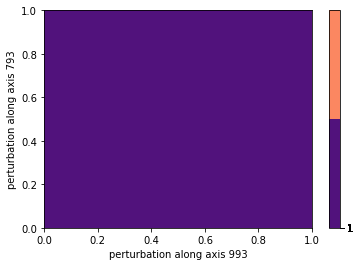

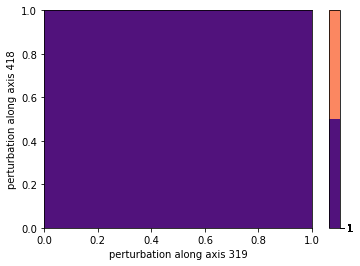

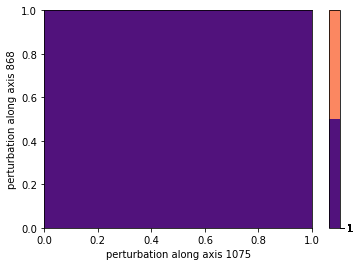

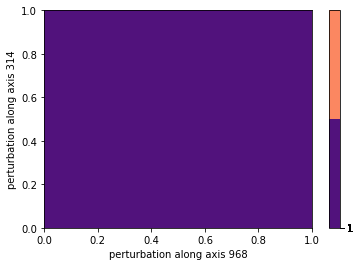

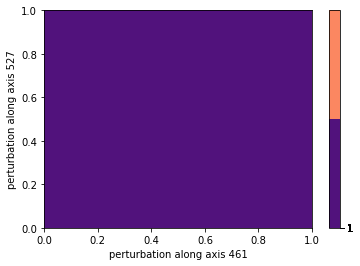

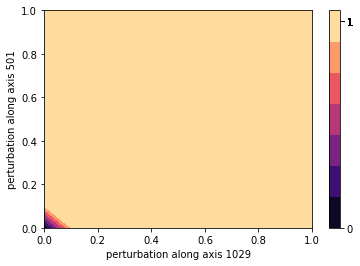

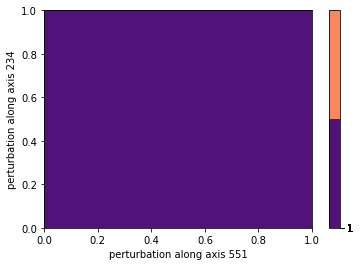

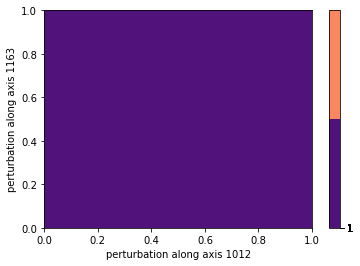

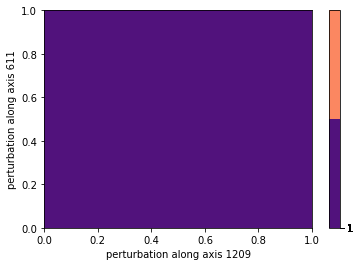

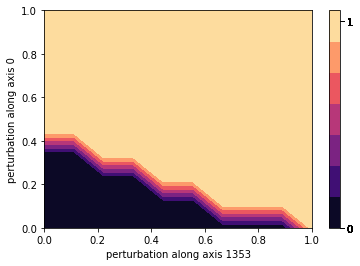

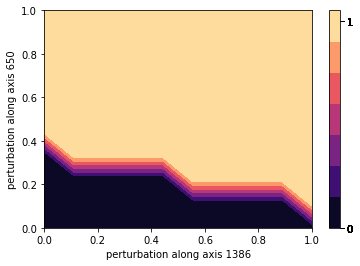

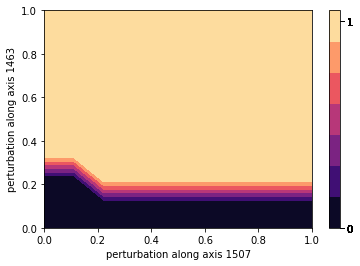

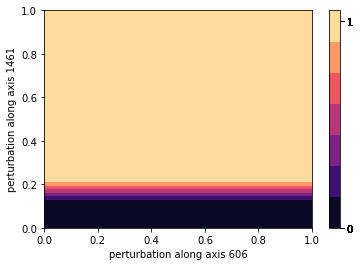

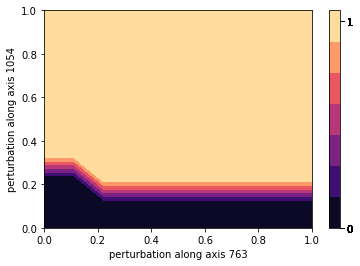

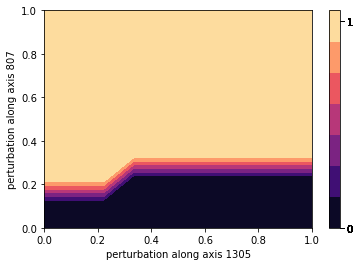

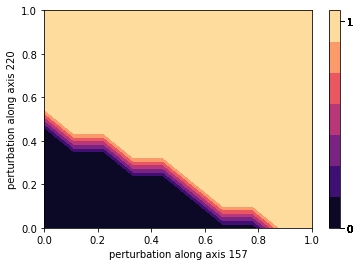

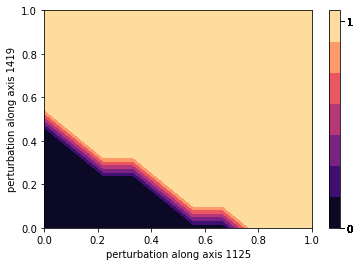

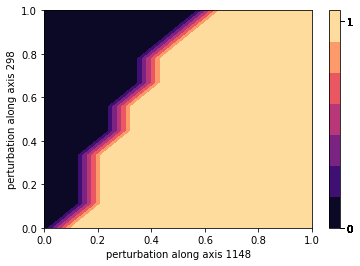

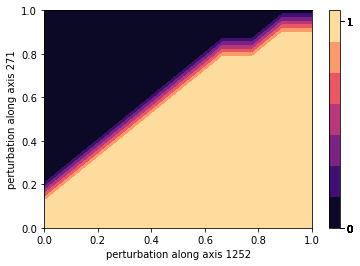

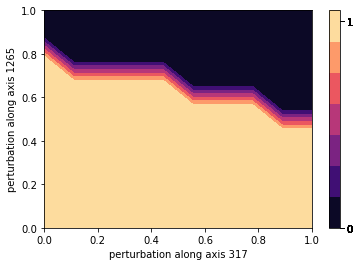

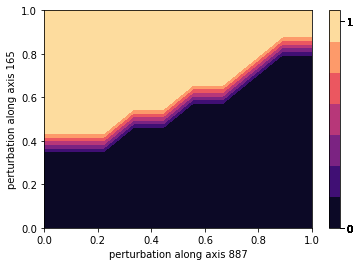

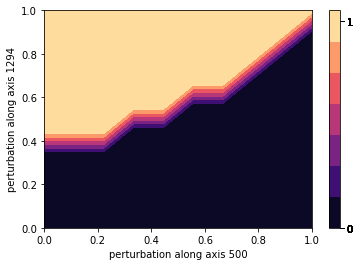

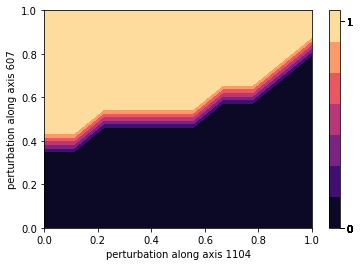

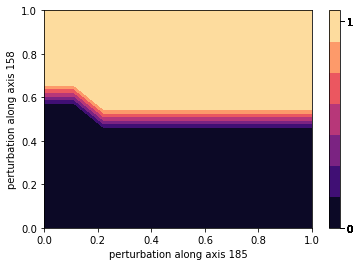

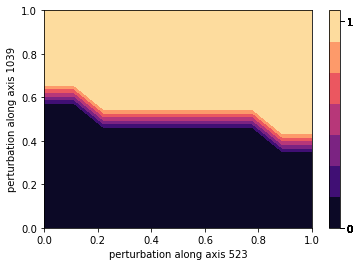

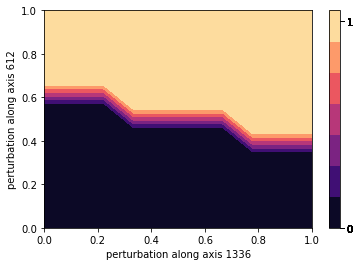

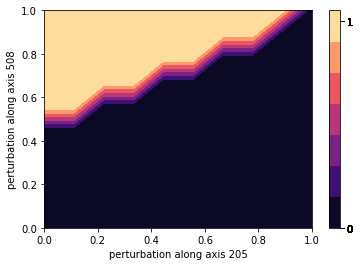

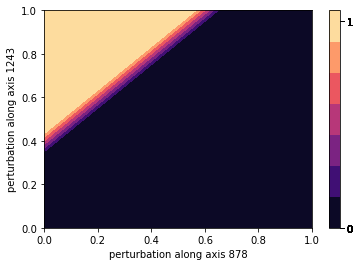

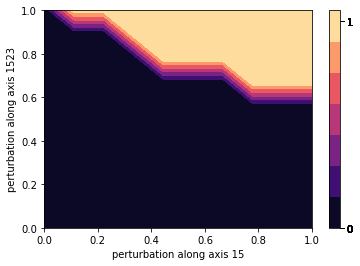

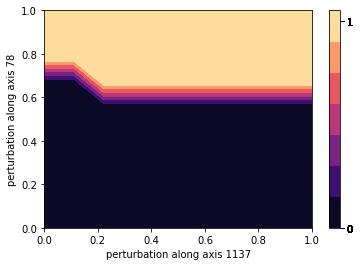

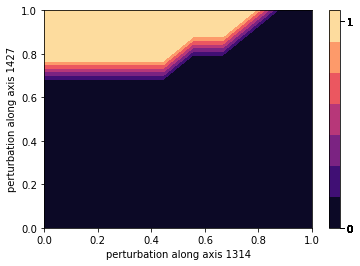

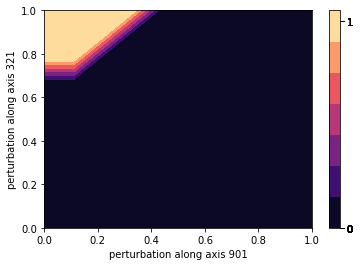

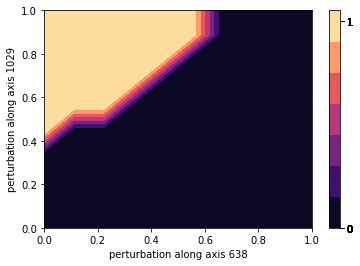

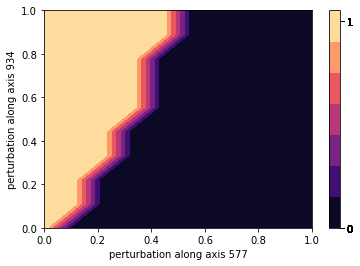

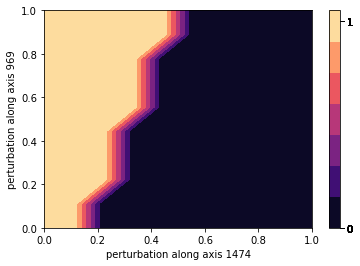

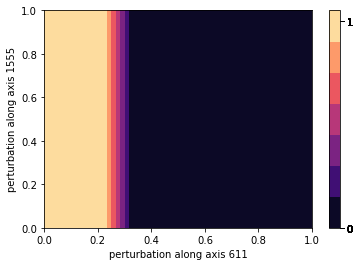

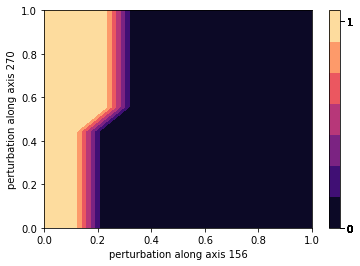

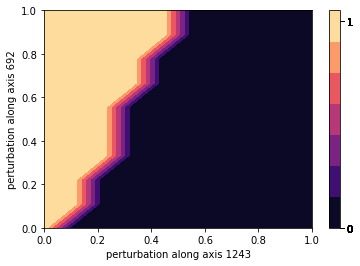

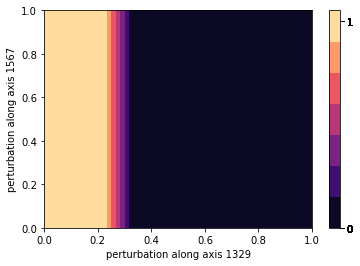

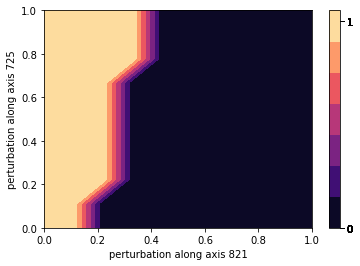

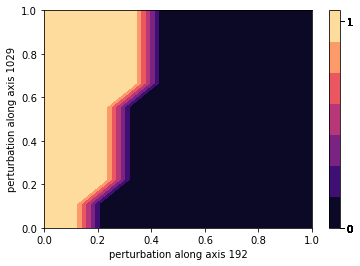

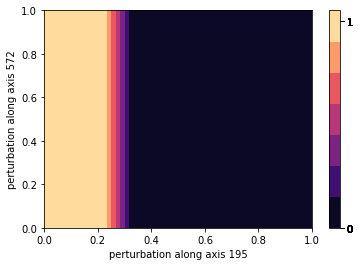

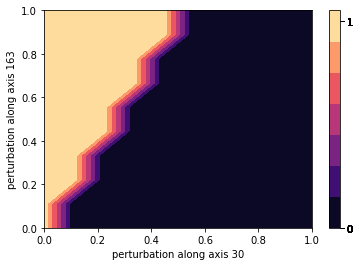

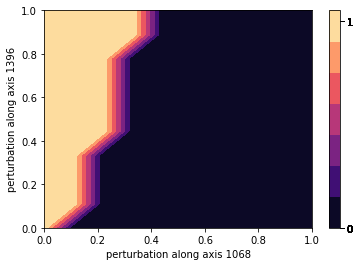

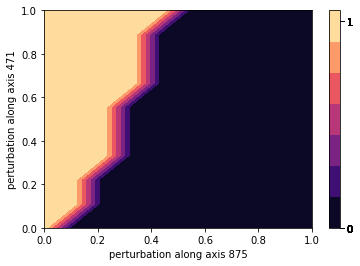

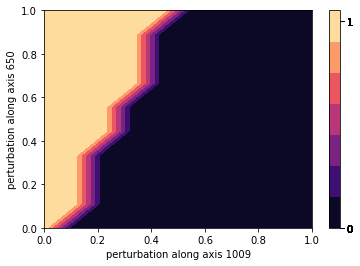

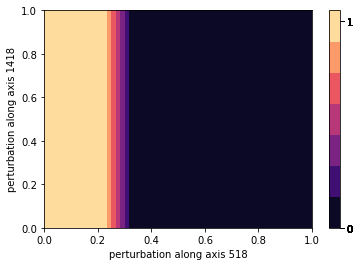

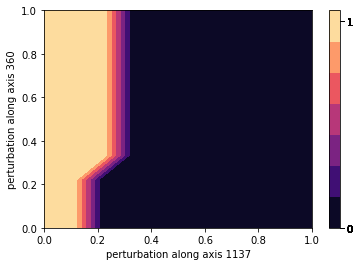

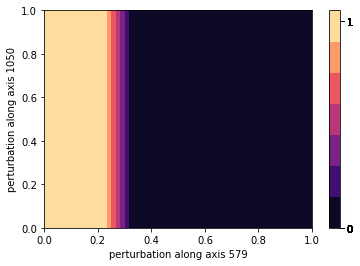

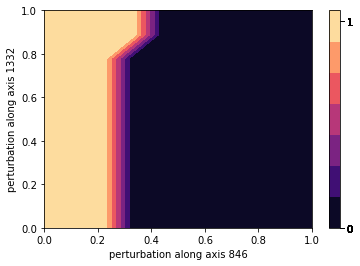

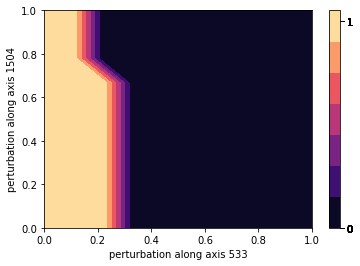

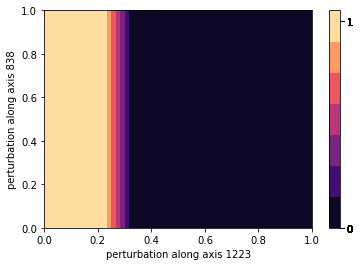

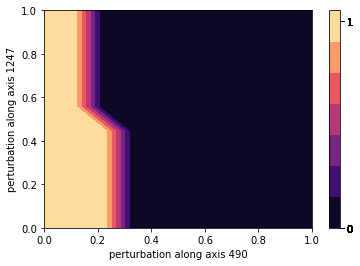

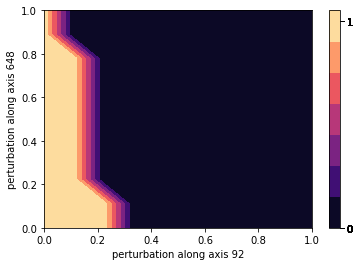

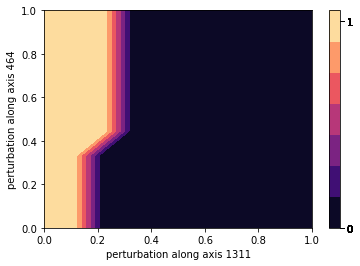

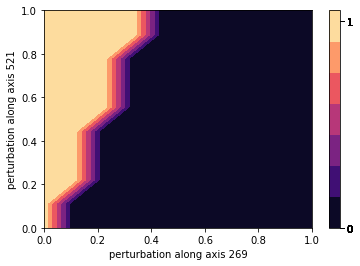

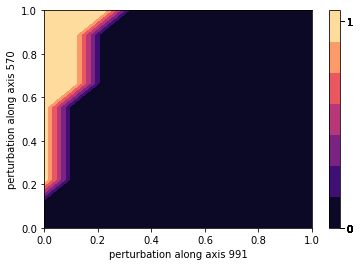

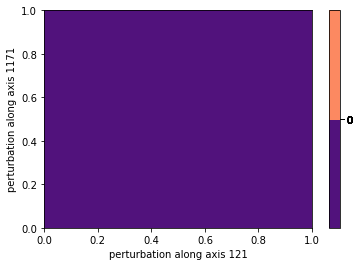

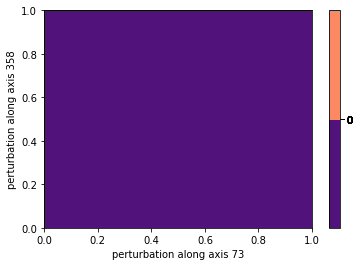

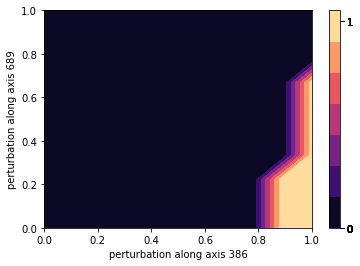

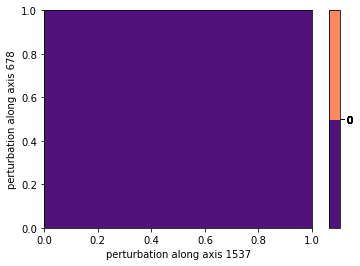

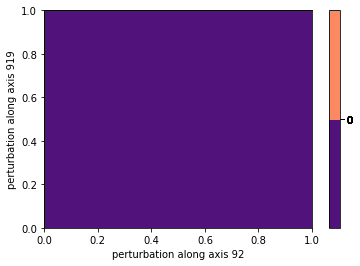

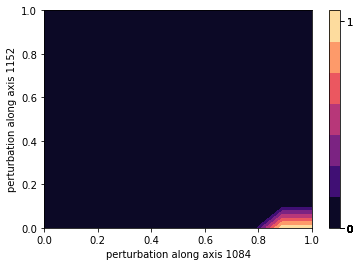

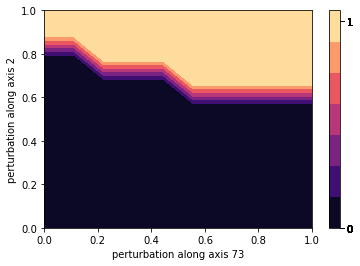

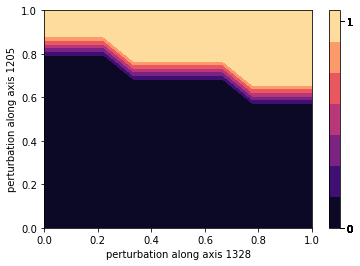

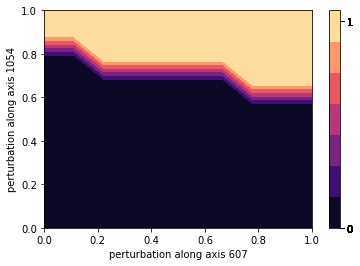

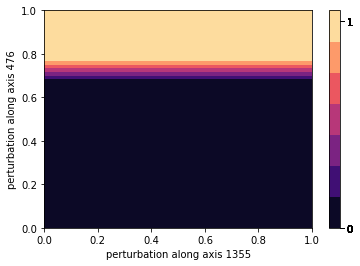

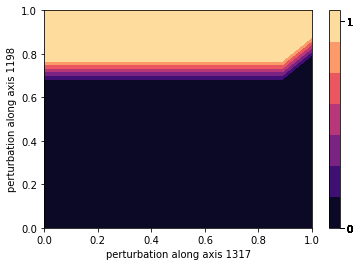

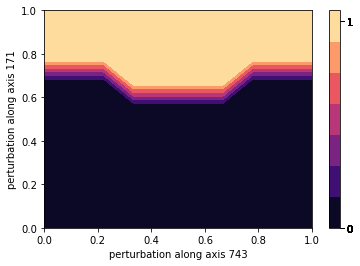

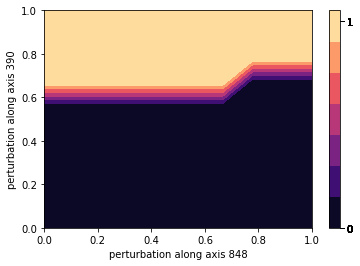

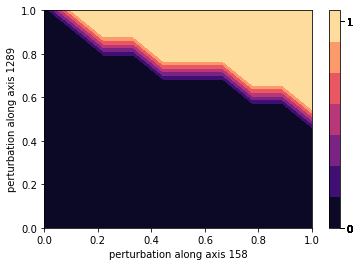

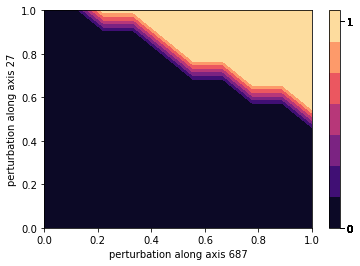

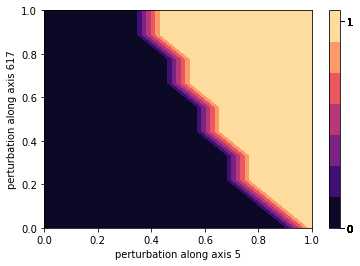

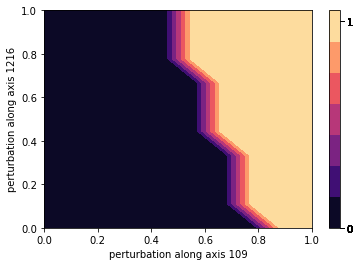

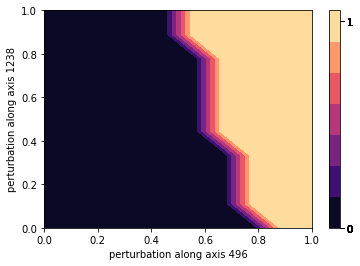

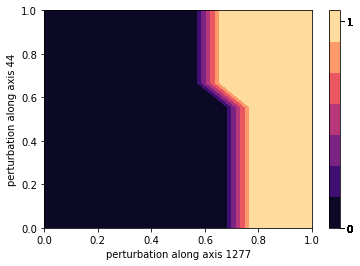

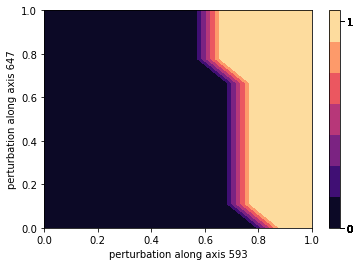

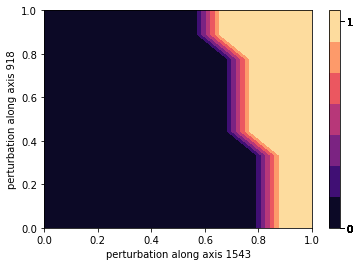

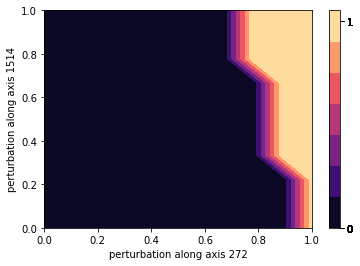

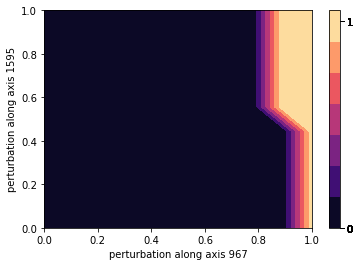

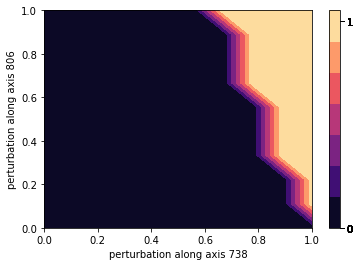

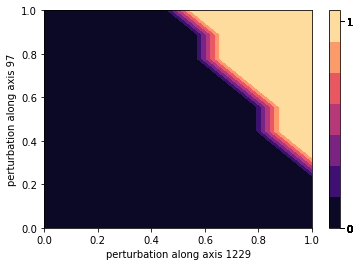

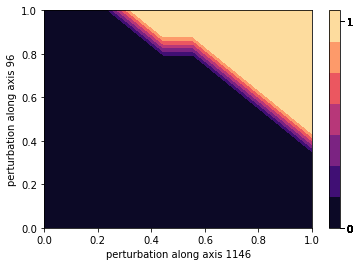

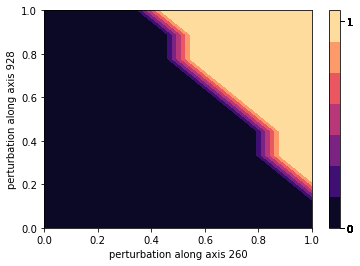

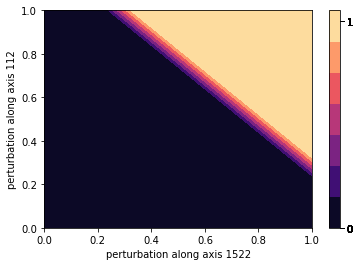

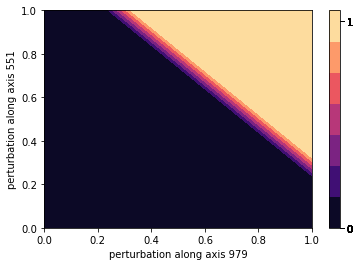

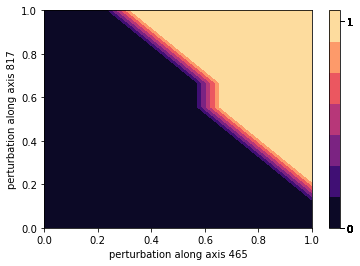

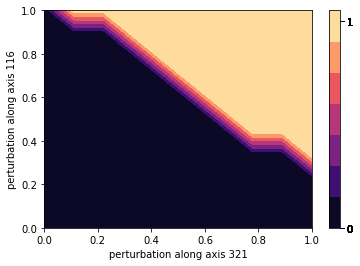

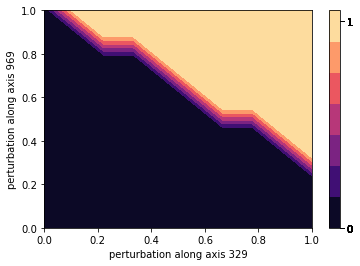

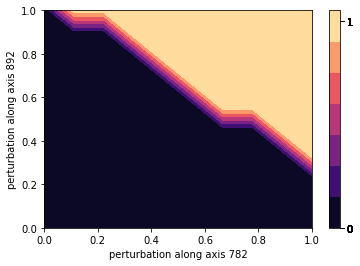

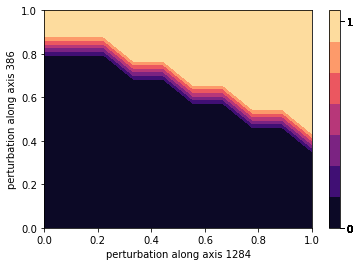

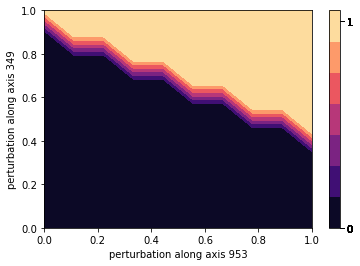

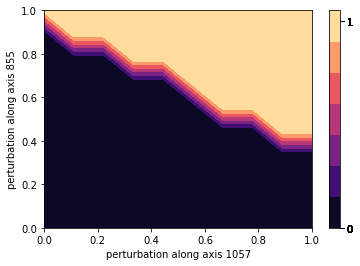

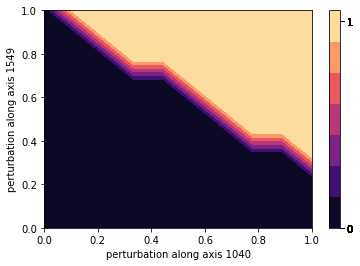

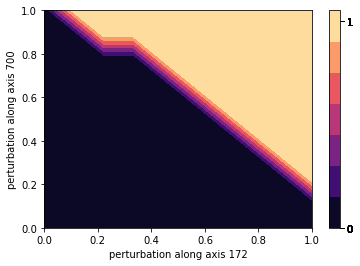

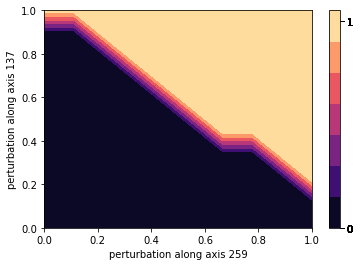

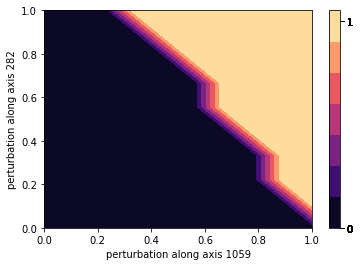

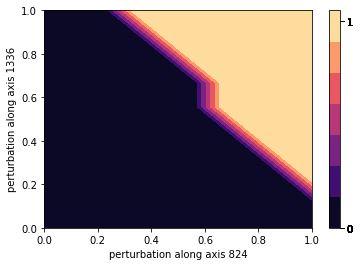

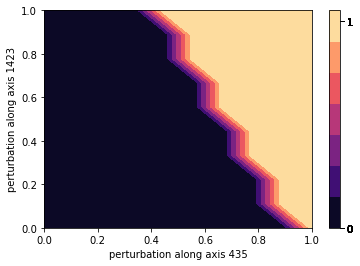

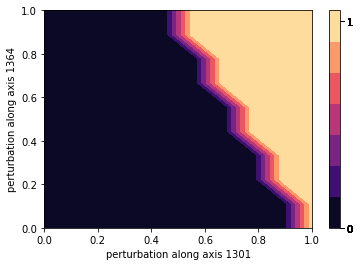

In [44]:
from collections import Counter
import random
print("training set has shape:",X_t.shape)
m=np.random.randint(0,X_t.shape[0])
#randomly sample a training example
value= X_t[36]
n=100
value=np.array([value for i in range(n)])
def plot_dec_bound(axis1,axis2,value):
    
    h = int(np.sqrt(n))  # step size in the mesh
    #create a mesh to plot in
    xx, yy = np.meshgrid(np.linspace(0, 1, h),
                       np.linspace(0,1, h))
    data1 = np.c_[xx.ravel(), yy.ravel()]
    data=np.reshape(data1,(data1.shape[0],data1.shape[1],1))

    meshgrid =[]
    #select the axis to visualise decision boundary about
    value[:,:,x]=data[:,0,:]
    value[:,:,y]=data[:,1,:]
    Z = model.predict(value)
    #convert the predictions into binary
    for j in range(len(Z)):
        if Z[j][0]>0.5:
            Z[j][0]=1
        else:
            Z[j][0]=0
    Z = Z.reshape(xx.shape)
    plt.contourf(xx,yy,Z,cmap="magma",alpha = 1)
    plt.colorbar(ticks=Z)
    plt.xlabel("perturbation along axis %s" %axis1)
    plt.ylabel("perturbation along axis %d" %axis2)
    path ="images\exobound_"+ str(i)+".jpg"
    plt.savefig(path)
    plt.show()
for i in range(100):
    x,y=np.random.randint(0,value.shape[2]-1,2)
    plot_dec_bound(x,y,value)